In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re


In [2]:
lyrics_df = pd.read_csv("song_lyrics.csv")
spotify_df = pd.read_csv("spotify.csv")

In [3]:
print(lyrics_df.head())

print(len(lyrics_df))

               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   

                                              lyrics  id language_cld3  \
0  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...   1            en   
1  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...   3            en   
2  Maybe cause I'm eatin\nAnd these bastards fien...   4            en   
3  [Produced by Kanye West and Brian Miller]\n\n[...   5            en  

In [4]:
print(spotify_df.head())
print(len(spotify_df))

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


In [8]:
def normalize_text(text):
    if pd.isnull(text):
        return ""
    return text.lower().strip()

lyrics_df['title_norm'] = lyrics_df['title'].apply(normalize_text)
lyrics_df['artist_list'] = lyrics_df['artist'].apply(normalize_text)

spotify_df['title_norm'] = spotify_df['track_name'].apply(normalize_text)
spotify_df['artist_norm'] = spotify_df['artists'].apply(normalize_text)

spotify_df['artist_list'] = spotify_df['artist_norm'].apply(lambda x: [a.strip() for a in x.split(';')])
spotify_exploded = spotify_df.explode('artist_list')

lyrics_df['title_norm'] = lyrics_df['title'].str.lower().str.strip()
spotify_exploded['title_norm'] = spotify_exploded['track_name'].str.lower().str.strip()

merged_df = spotify_exploded.merge(
    lyrics_df[["artist_list", "title_norm", "lyrics"]],
    on=["artist_list", "title_norm"],
    how="left"
)

merged_df = merged_df.dropna()

print(merged_df)
print(len(merged_df))

        Unnamed: 0                track_id  \
5                4  5vjLSffimiIP26QG5WcN2K   
6                5  01MVOl9KtVTNfFiBU9I7dc   
7                6  6Vc5wAMmXdKIAM7WUoEb7N   
12               9  7k9GuJYLp2AzqokyEdwEw2   
13              10  4mzP5mHkRvGxdhdGdAH7EJ   
...            ...                     ...   
158274      113982  39So2wAM6l3XKWDf5XjiIz   
158276      113984  0PjyOURxQ6wiHaBYXf53G2   
158285      113992  3FjOBB4EyIXHYUtSgrIdY9   
158286      113993  4OkMK49i3NApR1KsAIsTf6   
158291      113998  2e6sXL2bYv4bSz6VTdnfLs   

                                     artists  \
5                           Chord Overstreet   
6                               Tyrone Wells   
7       A Great Big World;Christina Aguilera   
12                            Ross Copperman   
13                              Zack Tabudlo   
...                                      ...   
158274                         Planetshakers   
158276                    Tenth Avenue North   
158285         

In [10]:
print(merged_df.columns)

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'title_norm', 'artist_norm', 'artist_list', 'lyrics'],
      dtype='object')


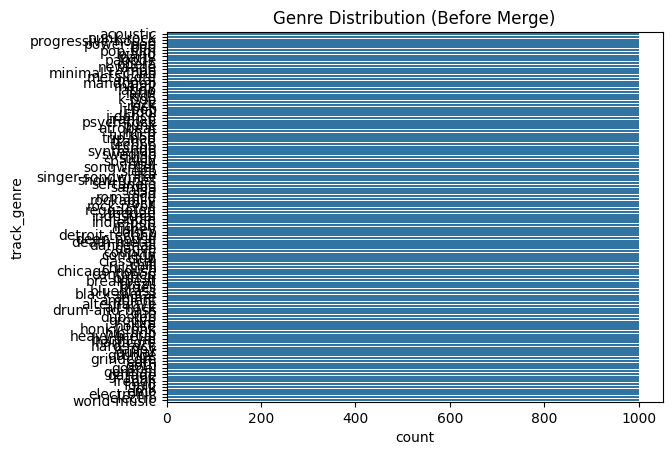

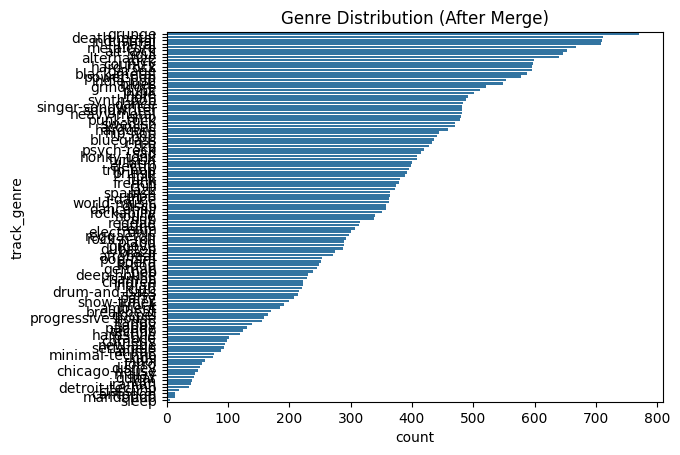

In [11]:
sns.countplot(y='track_genre', data=spotify_df, order=spotify_df['track_genre'].value_counts().index)
plt.title("Genre Distribution (Before Merge)")
plt.show()

sns.countplot(y='track_genre', data=merged_df, order=merged_df['track_genre'].value_counts().index)
plt.title("Genre Distribution (After Merge)")
plt.show()

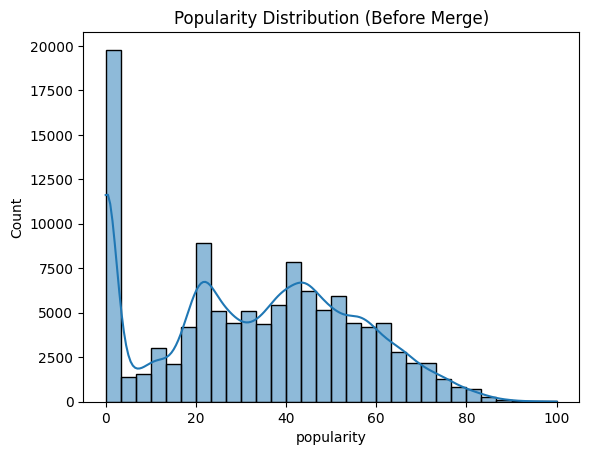

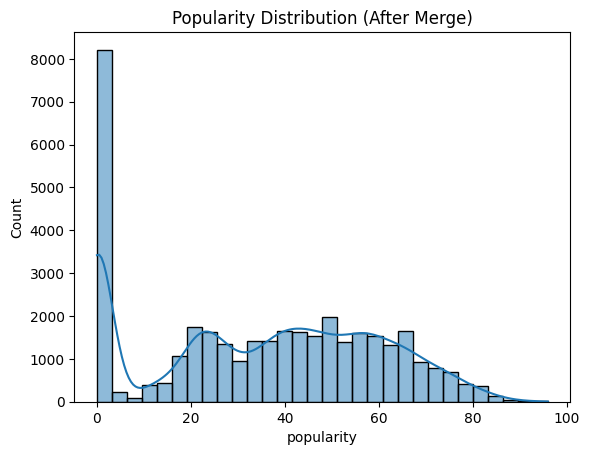

In [12]:
sns.histplot(spotify_df['popularity'], bins=30, kde=True)
plt.title("Popularity Distribution (Before Merge)")
plt.show()

sns.histplot(merged_df['popularity'], bins=30, kde=True)
plt.title("Popularity Distribution (After Merge)")
plt.show()

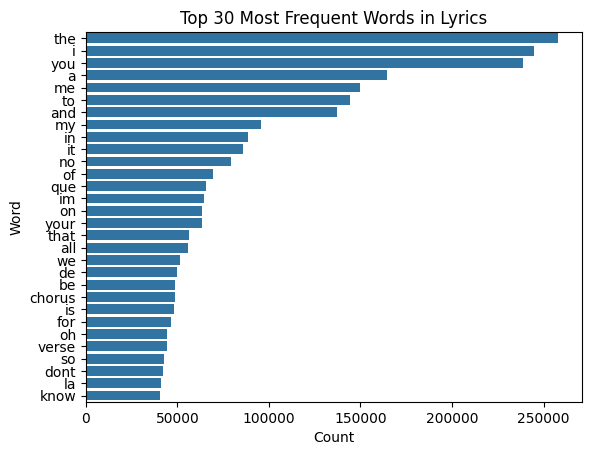

In [13]:
def tokenize(text):
    if pd.isnull(text):
        return []
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text.split()

all_words = [word for lyric in merged_df['lyrics'] for word in tokenize(lyric)]

word_counts = Counter(all_words)
common_words = word_counts.most_common(30)
words, counts = zip(*common_words)

sns.barplot(x=list(counts), y=list(words))
plt.title("Top 30 Most Frequent Words in Lyrics")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()
